# 準備

In [1]:
# GPU の確認
!nvidia-smi

Sun Sep 12 07:57:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Google Drive のマウント（Google Drive のファイルを読み書きできるようにする）
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 事前に upload したファイルを Google Drive からコピー

data_path = "/content/drive/My Drive/aitr/exercise_05_data/"

import shutil
import os
to_data_dir = "data/"
os.makedirs(to_data_dir, exist_ok=True)

fname_list = ["train.zip", "test.zip", "train.csv", "test.csv"]
for fname in fname_list:
    shutil.copy(data_path + fname, to_data_dir + fname)

In [4]:
# 事前に upload した zipファイルを解凍
%cd data
!unzip -qq -n train.zip
!unzip -qq -n test.zip
!ls
%cd ../

/content/data
test  test.csv	test.zip  train  train.csv  train.zip
/content


# メイン処理

## import

In [5]:
import os
import random
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader
import torchvision.models as models
import matplotlib.pyplot as plt

## 各種設定

In [6]:
# 各種設定
BATCH_SIZE = 50
MAX_EPOCH = 50
IMAGE_SIZE = 224
# シード値の固定
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# GPU利用設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =", device)

device = cuda


## データセット

In [7]:
# 自作のデータセットの処理
class MyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, target_transform=None, loader=default_loader):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir  # 画像が入っているディレクトリのパス
        self.loader = loader
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.df)

    # dataloaderで読み込むときの処理
    def __getitem__(self, idx):
        # filename取得
        img_name = self.df.iloc[idx, 0]
        # 画像のパス設定
        img_path = os.path.join(self.root_dir, img_name)
        # 画像読み込み
        image = self.loader(img_path)
        # user_id = self.df.iloc[idx, 2]

        label = self.df.iloc[idx, 1]

        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            label = self.target_transform(label)

        return image, label, img_path


# データの前処理を定義
transform = transforms.Compose(
    [
        # 画像のリサイズ
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        # tensorに変換
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ]
)

# 訓練用のデータ前処理を定義
train_transform = transforms.Compose(
    [
        # 画像のリサイズ
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        # ここにData augmentation処理を記述する
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.9, contrast=0.9),
        # tensorに変換
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ]
)


# 訓練データを取得
train_dataset = MyDataset(
    csv_file="./data/train.csv",
    root_dir='./data/train/',
    transform=transform,
)
# 訓練データの一部を検証データとして使用
num_train = len(train_dataset)
train_dataset, valid_dataset = torch.utils.data.random_split(
    train_dataset,
    [int(num_train * 0.8), int(num_train * 0.2)],
)
# DataLoaderを作成

# 訓練時のtransformを設定
train_dataset.dataset.transform = train_transform

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
# テストデータも同様
test_dataset = MyDataset(
    "./data/test.csv",
    root_dir='./data/test/',
    transform=transform,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

## モデル

In [8]:
# ニューラルネットワーク
model = models.resnet18()
# print(model)
model.fc = nn.Linear(512, 2)

model = model.to(device)

## 学習・評価

processing train data ...
epoch	train loss	valid loss	valid accuracy	processed time


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0	0.787938	0.684120	0.550000	10.385576
1	0.697760	0.731046	0.516667	20.441498
2	0.700132	0.715698	0.541667	30.278591
3	0.708593	0.726281	0.500000	40.121001
4	0.694554	0.678388	0.616667	49.997994
5	0.674270	0.707450	0.533333	60.054291
6	0.684329	0.688464	0.633333	69.903594
7	0.662233	0.762961	0.566667	79.856973
8	0.692345	0.669557	0.558333	89.702184
9	0.674870	0.805370	0.575000	99.565484
10	0.644392	0.726155	0.508333	109.476067
11	0.652758	0.783991	0.466667	119.346456
12	0.678335	0.692990	0.575000	129.106548
13	0.634278	0.761661	0.566667	138.891806
14	0.634031	1.157363	0.491667	148.650704
15	0.673160	0.711213	0.616667	158.410486
16	0.653747	0.730909	0.566667	168.205019
17	0.611923	0.679074	0.716667	178.049105
18	0.634487	0.740174	0.533333	188.100735
19	0.619448	0.895745	0.541667	198.016413
20	0.624674	0.622638	0.625000	207.998146
21	0.633154	0.683084	0.616667	218.015334
22	0.602165	0.894947	0.533333	228.039304
23	0.607681	0.735750	0.550000	238.102883
24	0.598350	0.789463	0.583333	248.17

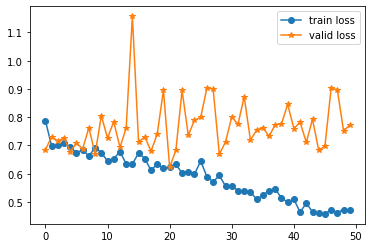

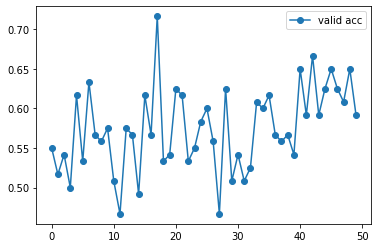

In [9]:
# 損失関数
loss_function = nn.CrossEntropyLoss()
# 勾配降下法を行うoptimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

start = time.time()
print('processing train data ...')

v_acc = []
t_acc = []
best_v_acc = 0
v_accuracy = []
print("epoch\ttrain loss\tvalid loss\tvalid accuracy\tprocessed time")
for epoch in range(MAX_EPOCH):
    model.train()
    train_loss_list = []
    # DataLoaderをfor文で回すと入力と正解ラベルが得られる
    for x, label, img_path in train_loader:
        x = x.to(device)
        label = label.to(device)
        # 勾配を0に初期化
        optimizer.zero_grad()
        # 順伝播
        output = model(x)
        # 誤差の計算
        loss = loss_function(output, label)
        # 誤差逆伝播
        loss.backward()
        # パラメータ更新
        optimizer.step()
        # ミニバッチの訓練誤差をlistに追加
        train_loss_list.append(loss.item())
    # 各ミニバッチでの訓練誤差の平均を取り，本エポックでの訓練誤差とする
    train_loss_mean = np.mean(train_loss_list)

    # 検証データでも同様に誤差を計算
    # モデルを評価する時は model.eval() とする
    model.eval()
    valid_loss_list = []
    valid_correct, valid_total = 0, 0
    for x, label, img_path in valid_loader:
        x = x.to(device)
        label = label.to(device)
        with torch.no_grad(): # torch.no_grad() とすると勾配の計算をしなくなる
            output = model(x)
        loss = loss_function(output, label)
        valid_loss_list.append(loss.item())

        pred = output.argmax(dim=1, keepdim=True)
        # 正解ラベルと比較，一致している数を加算
        valid_correct += pred.eq(label.view_as(pred)).sum().item()
        # 正解率(accuracy)を出すためにテストデータの数も加算
        valid_total += label.size()[0]

    valid_loss_mean = np.mean(valid_loss_list)

    valid_accuracy = valid_correct / valid_total

    print("{0}\t{1:.6f}\t{2:.6f}\t{3:.6f}\t{4:.6f}".format(epoch, train_loss_mean, valid_loss_mean, valid_accuracy, time.time() - start))
    t_acc.append(train_loss_mean)
    v_acc.append(valid_loss_mean)
    v_accuracy.append(valid_accuracy)
    # モデル保存
    if valid_accuracy > best_v_acc:
        best_v_acc = valid_accuracy
        model_dir = "./model/"
        os.makedirs(model_dir, exist_ok=True)
        save_path = model_dir + "cnn.pt"
        torch.save(model.state_dict(), save_path)

# 可視化コード
fig, ax = plt.subplots(1,1)
ax.plot(t_acc, label="train loss", marker="o")
ax.plot(v_acc, label="valid loss", marker="*")
ax.legend()
plt.savefig("losscurve.png", bbox_inches="tight")

fig, ax = plt.subplots(1,1)
ax.plot(v_accuracy, label="valid acc", marker="o")
ax.legend()
plt.savefig("acccurve.png", bbox_inches="tight")

# モデル読込
model.load_state_dict(torch.load("./model/cnn.pt"))

# モデルの評価(テストデータを使用)
print('processing test data ...')
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
for x, label, img_path in test_loader:
    x = x.to(device)
    label = label.to(device)
    with torch.no_grad():
        output = model(x)
    loss = loss_function(output, label)
    # 出力値が最大のインデックスを取得
    pred = output.argmax(dim=1, keepdim=True)
    # 正解ラベルと比較，一致している数を加算
    test_correct += pred.eq(label.view_as(pred)).sum().item()
    # 正解率(accuracy)を出すためにテストデータの数も加算
    test_total += label.size()[0]

test_accuracy = test_correct / test_total
print("Test accuracy :", test_accuracy)

# 演習用 混同行列の出力・不正解画像の出力

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


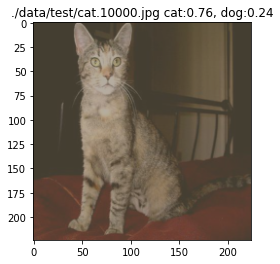

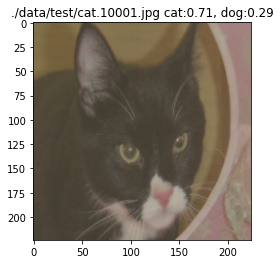

In [10]:
# モデル読込
model.load_state_dict(torch.load("./model/cnn.pt"))

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # データセットのtransformで行った正規化処理の逆変換
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# TODO 不正解だった画像の出力
# TODO 混同行列の出力
# 参考：第3回のコード cnn_predict.py
# https://github.com/HarmoLab/aitr2020/blob/master/excercise_03/cnn_predict.py

# imshow 利用例
model.eval()
softmax = nn.Softmax()
for img, label, img_path in test_loader:
    img = img.to(device)
    output = model(img).to("cpu")
    prob = softmax(output).to("cpu")
    img = img.to("cpu")
    
    # imshow で画像を出力可能
    title = "{0} cat:{1:.2f}, dog:{2:.2f}".format(img_path[0], prob[0][0], prob[0][1])
    imshow(img[0], title=title)
    title = "{0} cat:{1:.2f}, dog:{2:.2f}".format(img_path[1], prob[1][0], prob[1][1])
    imshow(img[1], title=title)
    break
